# Spatial Target Cells

Analyses for if cells care about the spatial target.

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import (compute_occupancy, compute_spatial_bin_edges,
                                          compute_spatial_bin_assignment, compute_bin_time)
from spiketools.spatial.utils import get_pos_ranges, get_bin_width
from spiketools.spatial.information import compute_spatial_information_2d
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue
from spiketools.plts.space import plot_positions, plot_heatmap
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.utils import restrict_range, get_value_by_time, get_value_by_time_range
from spiketools.utils.trials import epoch_data_by_range, epoch_spikes_by_range

# Import plot function
from spiketools.plts.trials import plot_rasters
from spiketools.plts.stats import plot_surrogates

import pandas as pd
# import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from collections import Counter

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions, compute_bin_firing
from target import compute_spatial_target_bins

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH')

In [6]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [7]:
# Define binning for chests (spatial target)
chest_bins = [6, 8]

# Define minimum required occupancy (in seconds)
min_occ = 1

In [8]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'
n_surrogates = 100

In [9]:
# Set example unit to analyze
uind = 36

## Load Data

In [10]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [11]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

#### Get Trial Data


In [12]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [13]:
# Extract behavioural markers of interest
nav_starts = nwbfile.trials['navigation_start'].data[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

#### Extract Spike Data

In [14]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [15]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

#### Extract Position Data

In [16]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [17]:
# Get the chest positions & trial indices
chest_xs, chest_ys = nwbfile.acquisition['chest_positions']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

## Chest Positions

In [18]:
# Check chest position range
print('Chest X position range: {:1.2f} - {:1.2f}'.format(np.min(chest_xs), np.max(chest_xs)))
print('Chest Y position range: {:1.2f} - {:1.2f}'.format(np.min(chest_ys), np.max(chest_ys)))

Chest X position range: 362.86 - 406.85
Chest Y position range: 321.34 - 396.47


In [19]:
# Check traversal position range
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[0, :]), np.max(positions[0, :])))
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[1, :]), np.max(positions[1, :])))

Position X range: 365.40 - 404.59
Position X range: 285.00 - 433.00


In [20]:
# Select the position values for navigation periods
_, positions_trials = epoch_data_by_range(ptimes, positions,
                                          nwbfile.trials.navigation_start[:],
                                          nwbfile.trials.navigation_stop[:])

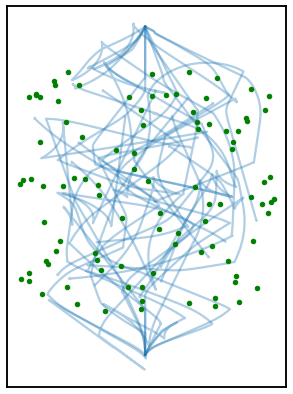

In [21]:
# Plot the subject positions, overlaid with chest positions
plot_positions(positions_trials, figsize=(5, 7))
plt.gca().plot(chest_xs, chest_ys, '.g')# Compute edges for chest binning

In [22]:
# Compute edges for chest binning
area_range = [[360, 410], [320, 400]]
x_edges, y_edges = compute_spatial_bin_edges(positions, chest_bins, area_range=area_range)

In [23]:
# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])

ch_xbin, ch_ybin = compute_spatial_bin_assignment(chest_pos, x_edges, y_edges)

# Fix offset of chest binning
ch_xbin = ch_xbin - 1 
ch_ybin = ch_ybin - 1 

## Single Trail

In [24]:
# Get trial information
t_ind = 10

t_st = nwbfile.trials['navigation_start'][t_ind]
ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
t_en = ch_openings[-1]

In [25]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [26]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [27]:
# Restrict spikes to the start of nav and the end of chest opening
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

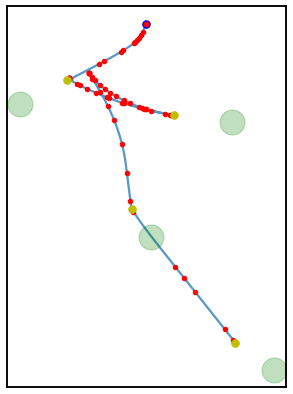

In [28]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
plot_positions(t_pos, alpha=0.75, figsize=(5, 7))
ax = plt.gca()
ax.plot(*t_pos[:, 0], 'b.', ms=15)
ax.plot(t_spike_xs, t_spike_ys, '.r')
[ax.plot(*cht, 'y.', ms=15) for cht in ch_times];
ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=50, alpha=0.25)

## Spatial Target Bins

In [29]:
# Compute chest occupancy
chest_occupancy = compute_bin_firing(ch_xbin, ch_ybin, chest_bins)

In [30]:
# Check the number of chests per bin
print("Range of chests per bin: {:1.0f} - {:1.0f}".format(\
    np.min(chest_occupancy), np.max(chest_occupancy)))

Range of chests per bin: 0 - 5


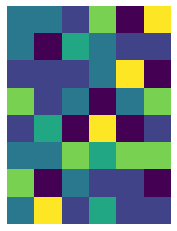

In [31]:
# Plot chest occupancy
plot_heatmap(chest_occupancy, transpose=True)

In [32]:
# Collect firing per chest location across all trials
target_bins = compute_spatial_target_bins(spikes, nav_starts, chest_openings, chest_trials, 
                                          ptimes, positions, chest_bins, ch_xbin, ch_ybin)

In [33]:
# Check range of firing across spatial target bins
np.min(target_bins), np.max(target_bins)

(0.0, 23.715288894873463)

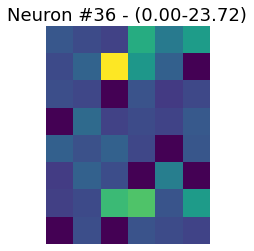

In [34]:
# Check the firing rate per spatial destination for an example neuron
plot_heatmap(target_bins, transpose=True,
             title='Neuron #{} - ({:1.2f}-{:1.2f})'.format(uind, np.min(target_bins), np.max(target_bins)))

# ANOVA TEST

### Use fr ~ C(target_bin), real data

#### Single Trial

In [35]:
# Collect firing per chest location for one selected trial
target_bins = np.zeros(chest_bins)

t_ind= 6
t_st = nav_starts[t_ind]
ch_openings = chest_openings[t_ind]
t_en = ch_openings[-1]

t_mask = chest_trials == t_ind

t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
count.update(np.digitize(t_spikes, ch_openings))

frs = np.array(list(count.values())) / seg_times

cur_ch_xbin = ch_xbin[t_mask]
cur_ch_ybin = ch_ybin[t_mask]

for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
    target_bins[xbin, ybin] = fr

In [36]:
# Collect firing per chest location for each trial

target_bins_1d = np.zeros([n_trials, 48])
for t_ind in range(n_trials):
    
    # Get trial information
    t_st = nav_starts[t_ind]
    ch_openings = chest_openings[t_ind]
    t_en = ch_openings[-1]

    t_mask = chest_trials == t_ind
    
    # Select chest openings for the current trial
    t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
    ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]
    
    # Restrict spikes to the chest-opening period
    t_spikes = restrict_range(spikes, t_st, t_en)
    t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)
    
    # compute firing rate per bin per trial
    seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
    count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
    count.update(np.digitize(t_spikes, ch_openings))

    frs = np.array(list(count.values())) / seg_times

    cur_ch_xbin = ch_xbin[t_mask]
    cur_ch_ybin = ch_ybin[t_mask]
    
    target_bins = np.zeros(chest_bins)
    for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
        target_bins[xbin, ybin] = fr
        
    target_bins_1d[t_ind,:] = target_bins.flatten()

In [37]:
# create the bin label
target_bins_trial=target_bins_1d.flatten()

target_bin_label = np.array(range(0, 48))
target_bin_label = np.tile(target_bin_label,n_trials)

In [38]:
# create the dataframe for ANOVA
merged_array = np.transpose(np.vstack([target_bin_label,target_bins_trial]))
df = pd.DataFrame(merged_array,columns=['target_bin', 'fr'] )

df.head(10)

,target_bin,fr
0,0.0,0.000000
1,1.0,8.527265
2,2.0,0.000000
3,3.0,0.000000
4,4.0,0.000000
5,5.0,0.000000
6,6.0,13.692304
7,7.0,0.000000
8,8.0,0.000000
9,9.0,0.000000


In [39]:
# build the ANOVA model
model = smf.ols('fr ~ C(target_bin)', data=df).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                    sum_sq      df         F    PR(>F)
C(target_bin)   587.351090    47.0  1.533305  0.012842
Residual       8997.882963  1104.0       NaN       NaN


In [40]:
# get the F-value from ANOVA model
f_val = aov_table['F']['C(target_bin)']
print(f_val)

model.summary()

1.5333053630663762


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fr   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.533
Date:                Wed, 20 Apr 2022   Prob (F-statistic):             0.0128
Time:                        17:12:53   Log-Likelihood:                -2818.6
No. Observations:                1152   AIC:                             5733.
Df Residuals:                    1104   BIC:                             5976.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2700      0.583      0.463      0.643      -0.873       1.413
C(target_bin)[T.1.0]      1.5563      0.824      1.888      0.059      -0.061       3.173
C(target_bin)[T.2.0]     -0.0310      0.824     -0.038      0.970      -1.648       1.586
C(target_bin)[T.3.0]     -0.2700      0.824     -0.328      0.743      -1.887       1.347
C(target_bin)[T.4.0]      0.9491      0.824      1.152      0.250      -0.668       2.566
C(target_bin)[T.5.0]     -0.0958      0.824     -0.116      0.907      -1.713       1.521
C(target_bin)[T.6.0]      1.4894      0.824      1.807      0.071      -0.128       3.106
C(target_bin)[T.7.0]     -0.2700      0.824     -0.328      0.743      -1.887       1.347
C(target_bin)[T.8.0]      0.3294      0.824      0.400      0.689      -1.288       1.946
C(target_bin)[T.9.0]      0.3454      0.824      0.419      0.675      -1.272       1.962
C(target_bin)[T.10.0]     0.0895      0.824      0.109      0.914      -1.528       1.707
C(target_bin)[T.11.0]     0.0723      0.824      0.088      0.930      -1.545       1.689
C(target_bin)[T.12.0]     0.9871      0.824      1.198      0.231      -0.630       2.604
C(target_bin)[T.13.0]     0.0371      0.824      0.045      0.964      -1.580       1.654
C(target_bin)[T.14.0]     0.2584      0.824      0.314      0.754      -1.359       1.875
C(target_bin)[T.15.0]     2.7445      0.824      3.330      0.001       1.127       4.362
C(target_bin)[T.16.0]     1.2929      0.824      1.569      0.117      -0.324       2.910
C(target_bin)[T.17.0]     2.0357      0.824      2.470      0.014       0.419       3.653
C(target_bin)[T.18.0]    -0.2700      0.824     -0.328      0.743      -1.887       1.347
C(target_bin)[T.19.0]    -0.0747      0.824     -0.091      0.928      -1.692       1.542
C(target_bin)[T.20.0]     0.0385      0.824      0.047      0.963      -1.579       1.655
C(target_bin)[T.21.0]     0.4994      0.824      0.606      0.545      -1.118       2.116
C(target_bin)[T.22.0]     1.1217      0.824      1.361      0.174      -0.495       2.739
C(target_bin)[T.23.0]    -0.2700      0.824     -0.328      0.743      -1.887       1.347
C(target_bin)[T.24.0]     0.3422      0.824      0.415      0.678      -1.275       1.959
C(target_bin)[T.25.0]     0.2533      0.824      0.307      0.759      -1.364       1.870
C(target_bin)[T.26.0]     0.3663      0.824      0.445      0.657      -1.251       1.983
C(target_bin)[T.27.0]    -0.0459      0.824     -0.056      0.956      -1.663       1.571
C(target_bin)[T.28.0]     0.2656      0.824      0.322      0.747      -1.351       1.883
C(target_bin)[T.29.0]    -0.2700      0.824     -0.328      0.743      -1.887       1.347
C(target_bin)[T.30.0]     1.7358      0.824      2.106      0.035       0.119       3.353
C(target_bin)[T.31.0]  

# ANOVA Surrogate

### fr ~ C(target_bin), 100 surrogates

In [41]:
# get firing rate per bin, per trial, for shuffled data

times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, shuffle_min=20000) #regular circ
surrogates = []

for i, j in enumerate (times_shuffle):
    target_bins_1d = np.zeros([n_trials, 48])
    
    for t_ind in range(n_trials):
    # t_ind= 5
        t_st = nav_starts[t_ind]
        ch_openings = chest_openings[t_ind]
        t_en = ch_openings[-1]

        t_mask = chest_trials == t_ind

        t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
        ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

        t_spikes = restrict_range(times_shuffle[i], t_st, t_en)
        t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

        seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
        count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
        count.update(np.digitize(t_spikes, ch_openings))

        frs = np.array(list(count.values())) / seg_times

        cur_ch_xbin = ch_xbin[t_mask]
        cur_ch_ybin = ch_ybin[t_mask]

        target_bins = np.zeros(chest_bins)
        for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
            target_bins[xbin, ybin] = fr

        target_bins_1d[t_ind,:] = target_bins.flatten()
        
    target_bins_trial=target_bins_1d.flatten()

    target_bin_label = np.array(range(0, 48))
    target_bin_label = np.tile(target_bin_label,n_trials)

    merged_array = np.transpose(np.vstack([target_bin_label,target_bins_trial]))
    df = pd.DataFrame(merged_array,columns=['target_bin', 'fr'])
    
    model = smf.ols('fr ~ C(target_bin)', data=df).fit()
    aov_table = anova_lm(model, typ=2)
    f_val_surrs = aov_table['F']['C(target_bin)']
    
    surrogates.append(f_val_surrs)

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fr   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.475
Date:                Wed, 20 Apr 2022   Prob (F-statistic):             0.0215
Time:                        17:12:57   Log-Likelihood:                -2778.7
No. Observations:                1152   AIC:                             5653.
Df Residuals:                    1104   BIC:                             5896.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3375      0.563      0.600      0.549      -0.767       1.442
C(target_bin)[T.1.0]      1.9708      0.796      2.476      0.013       0.409       3.533
C(target_bin)[T.2.0]     -0.0558      0.796     -0.070      0.944      -1.618       1.506
C(target_bin)[T.3.0]     -0.3375      0.796     -0.424      0.672      -1.900       1.225
C(target_bin)[T.4.0]      0.6367      0.796      0.800      0.424      -0.925       2.199
C(target_bin)[T.5.0]      0.0221      0.796      0.028      0.978      -1.540       1.584
C(target_bin)[T.6.0]      1.3760      0.796      1.728      0.084      -0.186       2.938
C(target_bin)[T.7.0]     -0.3375      0.796     -0.424      0.672      -1.900       1.225
C(target_bin)[T.8.0]      0.2432      0.796      0.306      0.760      -1.319       1.805
C(target_bin)[T.9.0]      0.3304      0.796      0.415      0.678      -1.232       1.893
C(target_bin)[T.10.0]     0.1439      0.796      0.181      0.857      -1.418       1.706
C(target_bin)[T.11.0]    -0.0139      0.796     -0.017      0.986      -1.576       1.548
C(target_bin)[T.12.0]     0.5498      0.796      0.691      0.490      -1.012       2.112
C(target_bin)[T.13.0]    -0.0480      0.796     -0.060      0.952      -1.610       1.514
C(target_bin)[T.14.0]     0.1670      0.796      0.210      0.834      -1.395       1.729
C(target_bin)[T.15.0]     2.4855      0.796      3.122      0.002       0.923       4.048
C(target_bin)[T.16.0]     1.0721      0.796      1.347      0.178      -0.490       2.634
C(target_bin)[T.17.0]     1.3497      0.796      1.695      0.090      -0.212       2.912
C(target_bin)[T.18.0]    -0.3375      0.796     -0.424      0.672      -1.900       1.225
C(target_bin)[T.19.0]    -0.0398      0.796     -0.050      0.960      -1.602       1.522
C(target_bin)[T.20.0]    -0.1035      0.796     -0.130      0.897      -1.666       1.459
C(target_bin)[T.21.0]     0.5158      0.796      0.648      0.517      -1.046       2.078
C(target_bin)[T.22.0]     0.8189      0.796      1.029      0.304      -0.743       2.381
C(target_bin)[T.23.0]    -0.3375      0.796     -0.424      0.672      -1.900       1.225
C(target_bin)[T.24.0]     0.2364      0.796      0.297      0.767      -1.326       1.798
C(target_bin)[T.25.0]     0.2855      0.796      0.359      0.720      -1.277       1.848
C(target_bin)[T.26.0]     0.4678      0.796      0.588      0.557      -1.094       2.030
C(target_bin)[T.27.0]    -0.0523      0.796     -0.066      0.948      -1.614       1.510
C(target_bin)[T.28.0]     0.1869      0.796      0.235      0.814      -1.375       1.749
C(target_bin)[T.29.0]    -0.3375      0.796     -0.424      0.672      -1.900       1.225
C(target_bin)[T.30.0]     1.3207      0.796      1.659      0.097      -0.241       2.883
C(target_bin)[T.31.0]  

p-value: 0.03
z-score: 2.06


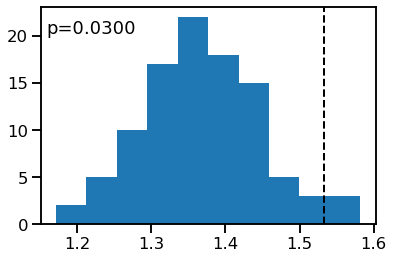

In [43]:
# Compute the empirical p-value based on surrogates
surr_p_val = compute_empirical_pvalue(f_val, surrogates)

# Compute z-score of the real F-value compared to surrogates
z_score = zscore_to_surrogates(f_val, surrogates)

# Print out the compute p-value and z-scored information
print('p-value: {:4.2f}'.format(surr_p_val))
print('z-score: {:4.2f}'.format(z_score))

# Plot the distribution of surrogates, comparing to real F-value
plot_surrogates(surrogates, f_val, surr_p_val)

## All Cells

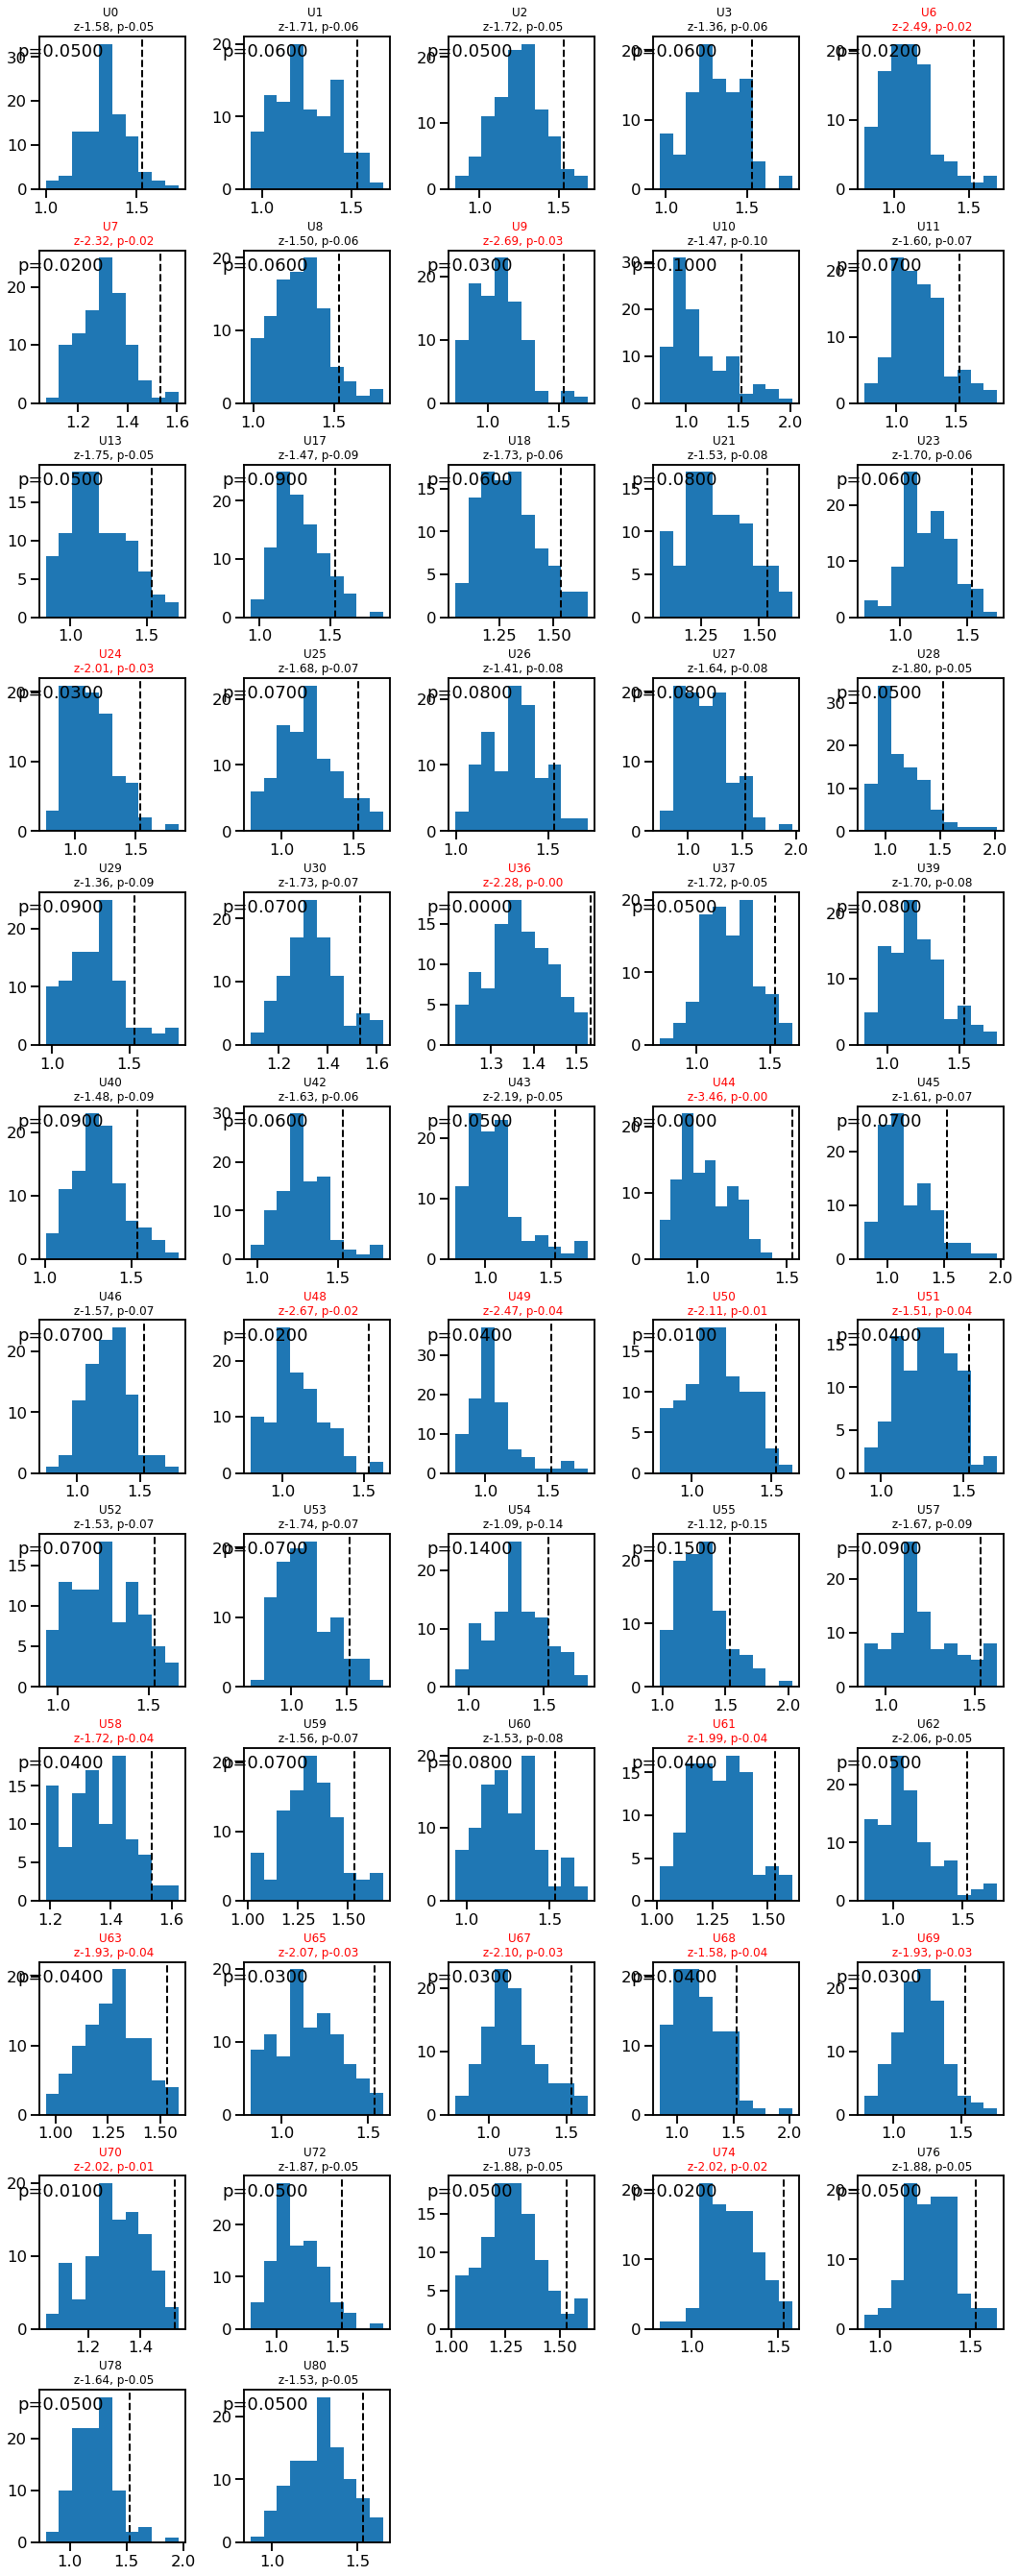

In [44]:
for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4, wspace=0.4)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii)
    times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, shuffle_min=20000) 
    surrogates = []

    for i, j in enumerate (times_shuffle):
        target_bins_1d = np.zeros([n_trials, 48])

        for t_ind in range(n_trials):
            
            t_st = nav_starts[t_ind]
            ch_openings = chest_openings[t_ind]
            t_en = ch_openings[-1]

            t_mask = chest_trials == t_ind

            t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
            ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

            t_spikes = restrict_range(times_shuffle[i], t_st, t_en)
            t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

            seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))
            count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
            count.update(np.digitize(t_spikes, ch_openings))

            frs = np.array(list(count.values())) / seg_times

            cur_ch_xbin = ch_xbin[t_mask]
            cur_ch_ybin = ch_ybin[t_mask]

            target_bins = np.zeros(chest_bins)
            
            for fr, xbin, ybin in zip(frs, cur_ch_xbin, cur_ch_ybin):
                target_bins[xbin, ybin] = fr

            target_bins_1d[t_ind,:] = target_bins.flatten()

        target_bins_trial=target_bins_1d.flatten()

        target_bin_label = np.array(range(0, 48))
        target_bin_label = np.tile(target_bin_label,n_trials)

        merged_array = np.transpose(np.vstack([target_bin_label,target_bins_trial]))
        df = pd.DataFrame(merged_array,columns=['target_bin', 'fr'])

        model = smf.ols('fr ~ C(target_bin)', data=df).fit()
        aov_table = anova_lm(model, typ=2)
        f_val_surrs = aov_table['F']['C(target_bin)']

        surrogates.append(f_val_surrs)
        
    # Compute the empirical p-value based on surrogates
    surr_p_val = compute_empirical_pvalue(f_val, surrogates)

    # Compute z-score of the real F-value compared to surrogates
    z_score = zscore_to_surrogates(f_val, surrogates)

    # Plot the distribution of surrogates, comparing to real F-value
    plot_surrogates(surrogates, f_val, surr_p_val, ax=ax)
    
    color = 'red' if surr_p_val < 0.05 else 'black'
    title = 'U{} \n z-{:1.2f}, p-{:1.2f}'.format(ii, z_score, surr_p_val)
    ax.set_title(title, fontdict={'fontsize' : 12}, color=color)

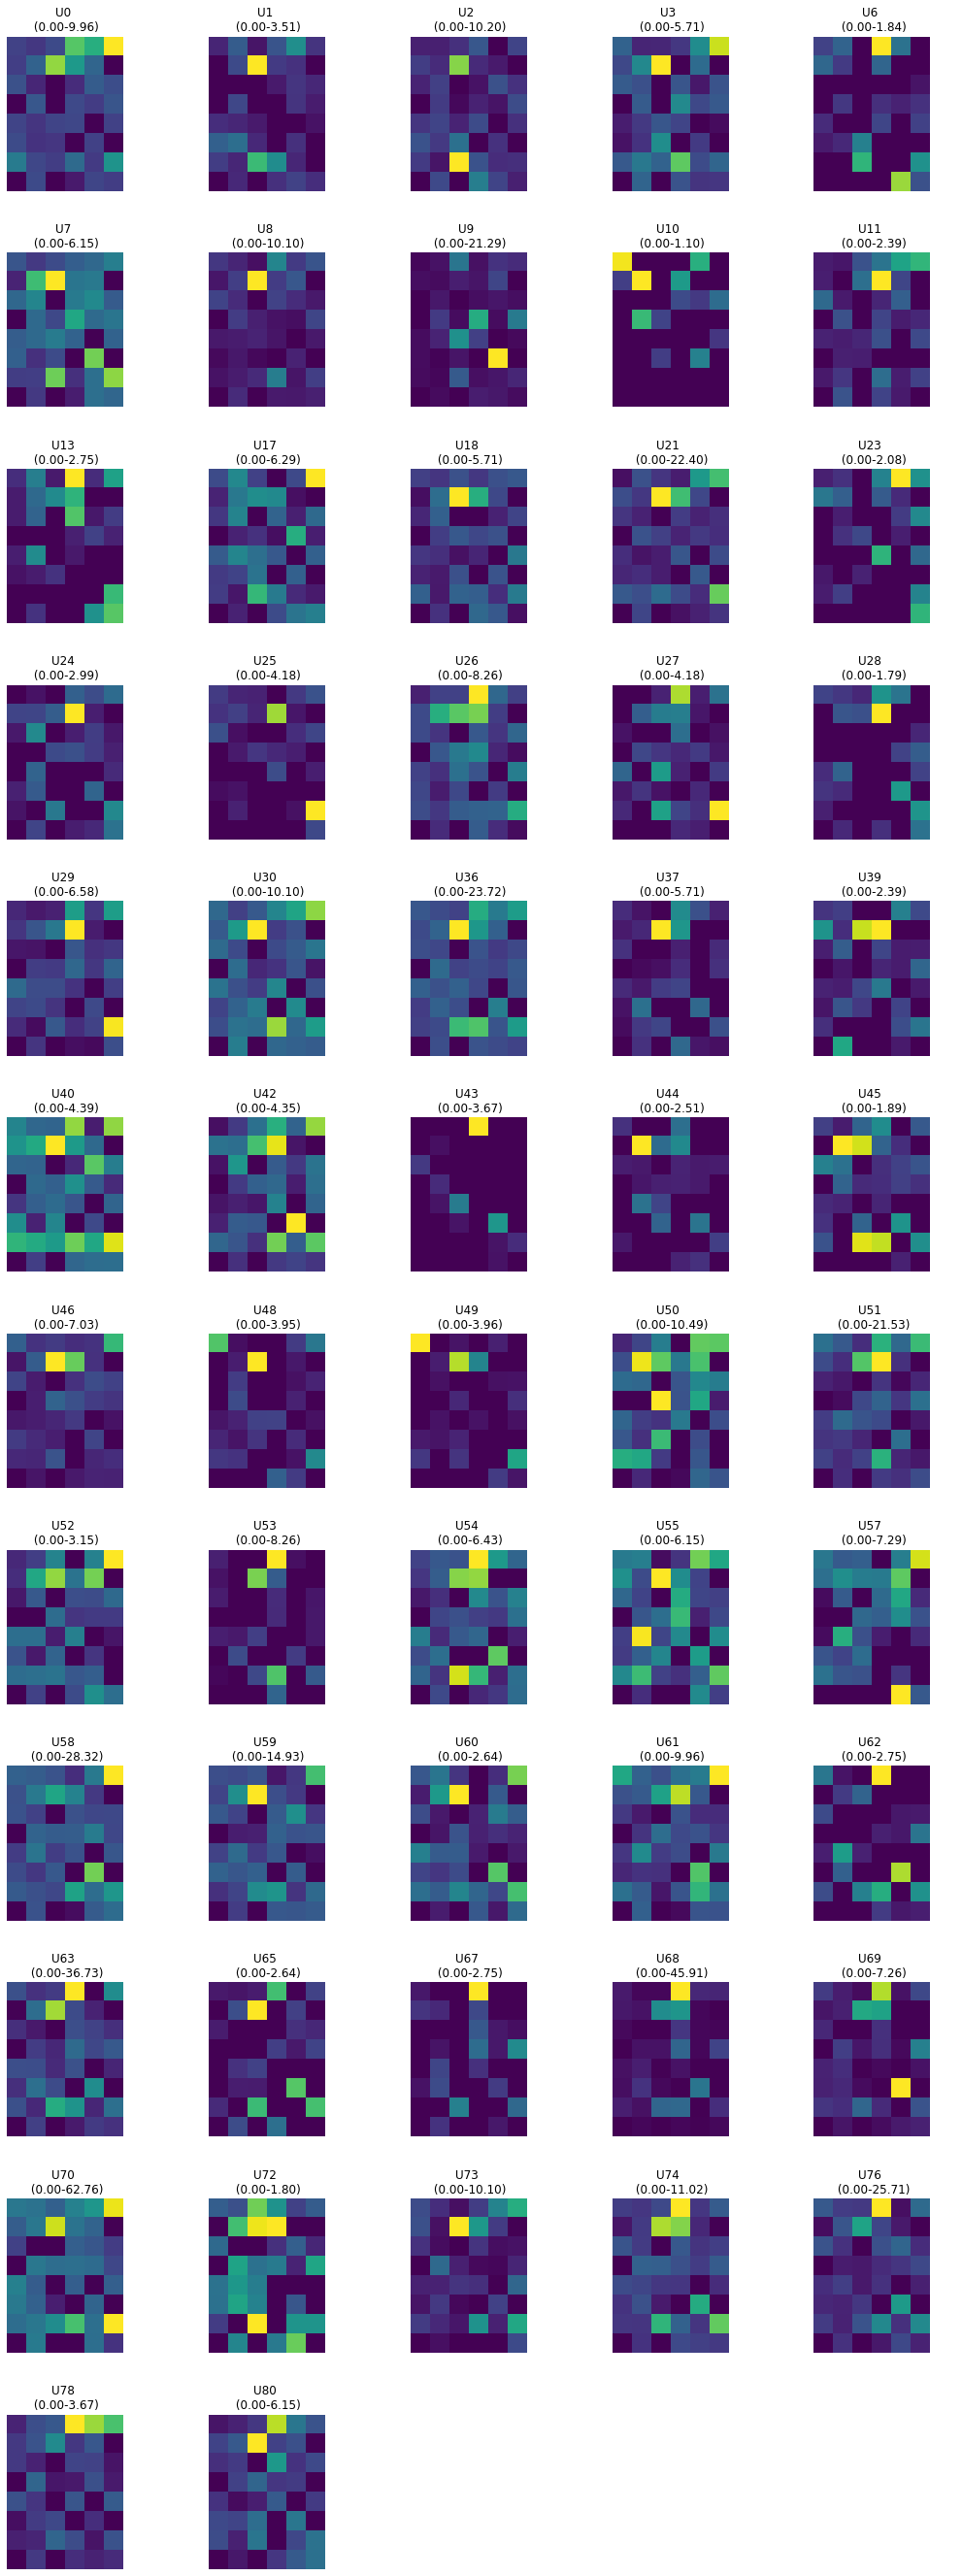

In [45]:
# Plot spatial target heat maps for all cells
for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii)

    # Collect firing per chest location across all trials    
    target_bins = compute_spatial_target_bins(spikes, nav_starts, chest_openings, chest_trials, 
                                              ptimes, positions, chest_bins, ch_xbin, ch_ybin)

    plot_heatmap(target_bins, transpose=True, ax=ax) 
    
    color = 'red' if surr_p_val < 0.05 else 'black'
    title = 'U{} \n ({:1.2f}-{:1.2f})'.format(\
        ii, np.min(target_bins), np.max(target_bins))
    
    ax.set_title(title, fontdict={'fontsize' : 12});